<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-тестирование-моделей" data-toc-modified-id="Обучение-и-тестирование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#Регрессор-на-основе-случайного-леса-RandomForestRegressor" data-toc-modified-id="Регрессор-на-основе-случайного-леса-RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Регрессор на основе случайного леса RandomForestRegressor</a></span></li><li><span><a href="#Линейный-регрессор-LinearRegression" data-toc-modified-id="Линейный-регрессор-LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейный регрессор LinearRegression</a></span></li><li><span><a href="#Линейный-регрессор-с-объединением-L1-и-L2-регуляризаций-ElasticNet" data-toc-modified-id="Линейный-регрессор-с-объединением-L1-и-L2-регуляризаций-ElasticNet-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейный регрессор с объединением L1 и L2 регуляризаций ElasticNet</a></span></li></ul></li><li><span><a href="#Сравнение-моделей-и-выводы" data-toc-modified-id="Сравнение-моделей-и-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение моделей и выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключим необходимые модули Python и определим пользовательские функции.

In [1]:
#!pip install scikit-learn==0.24.2
#!pip install pandas==1.3.2
#!pip install numpy==1.20.3
#!pip install matplotlib==3.4.2
#!pip install seaborn==0.11.2

import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
from IPython.display import clear_output

import html

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = None
pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose

Объявим константы и функции.

In [2]:
# Срез даты: первая половина марта 2018 
DATE_2018_03_FIRST_HALF_SLICE = slice('2018-03', '2018-03-14')

# Ширины окон скользящего среднего для определения тренда и суточных колебаний
ROLL_IR_TREND_SIZE = 24 * 7 # Неделя
ROLL_IR_DAILY_SIZE = 6 # Четверть суток

def make_features(data: pd.DataFrame, max_lag: int, rolling_mean: dict) -> pd.DataFrame:
    '''
    Функция добавляет временные признаки
    '''
    # Год, номер месяца в году, число, номер дня недели, вермя суток в часах
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.num_orders.shift(lag)
    # Сглаживание скользящим средним
    for feature_name, window_size in rolling_mean.items():
        data[feature_name] = data.num_orders.shift().rolling(window_size).mean()

In [3]:
def df_info(data_frame, nulls_percentage_round=1, deep_memory_usage=False):
    '''
    Выводит на экран общую информацию о таблице
    Входные параметры:
        data_frame             — таблица типа pd.DataFrame;
        nulls_percentage_round — знак, до которого происходит округление в столбце nulls_percentage отображаемой таблицы;
        deep_memory_usage      — глубокий анализ используемой памяти
    '''
    assert isinstance(data_frame, pd.DataFrame), 'Аргумент data_frame должен иметь тип pd.DataFrame'
    t = pd.concat(
        [
         
            data_frame.isna().sum().to_frame('nulls_count'),
            (100 * data_frame.isna().sum() / len(data_frame)).round(nulls_percentage_round).to_frame('nulls_percentage'),
            data_frame.dtypes.to_frame('dtype')
        ],
        axis=1
    )
    s = 'dtypes:'
    c = data_frame.dtypes.value_counts()
    for i in c.index:
        s += ' {0}({1})'.format(i, c[i])
    m = data_frame.memory_usage(deep=deep_memory_usage).sum()
    if int(m / 1024 ** 3):
        d, b = 1024 ** 3, 'GB'
    elif int(m / 1024 ** 2):
        d, b = 1024 ** 2, 'MB'
    else:
        d, b = 1024, 'KB'
    print(t)
    print('columns: ', data_frame.shape[1], ', rows: ', data_frame.shape[0], sep='')
    print(s)
    print('memory_usage: ', round(m / d, 1), '+ ' if not deep_memory_usage else ' ', b, sep='')

Загрузим данные.

In [4]:
# Возможные пути расположения файлов
filepaths = ['/datasets/taxi.csv', './taxi.csv', 'https://code.s3.yandex.net/datasets/taxi.csv']
for filepath in filepaths:
    try:
        taxi = pd.read_csv(filepath, index_col=0, parse_dates=[0])
        print('Таблица из файла ' + filepath + ' загружена в переменную taxi')
        break
    except Exception:
        continue
else:
    raise SystemExit('Файл с таблицей не найден ни по одному из путей в списке filepaths')

Таблица из файла https://code.s3.yandex.net/datasets/taxi.csv загружена в переменную taxi


Выведем начало таблицы и информацию о пропусках и типах данных.

In [5]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df_info(taxi)

            nulls_count  nulls_percentage  dtype
num_orders            0               0.0  int64
columns: 1, rows: 26496
dtypes: int64(1)
memory_usage: 414.0+ KB


Таблица содержит 26496 строк и не имеет пропусков.

Индексами таблицы являются даты. Для решения задач прогнозирования, временные метки должны быть расположения в хронологическом порядке. Убедимся в этом.

In [7]:
taxi.index.is_monotonic

True

Индексы упорядочены по возростанию и не требуют сортировки.

## Анализ

Определим границы анализируемого периода. Выведем первую и последнюю даты.

In [8]:
taxi.index[0], taxi.index[-1]

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Данные предоставлены с марта по август 2018 года.

Горизон прогнозирования составляет 1 час. Проведем соответствующее ресемплирование данных с суммированием внутри интервала для подсчета количества вызовов для каждого часа.

In [9]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проанализируем спрос на такси для ресемплированной таблицы с помощью библиотеки `statsmodels`, для этого декомпозируем кривую спроса на тренд, суточную составляющую и остаток декомпозиции. Визуализурем полученные составляющие.

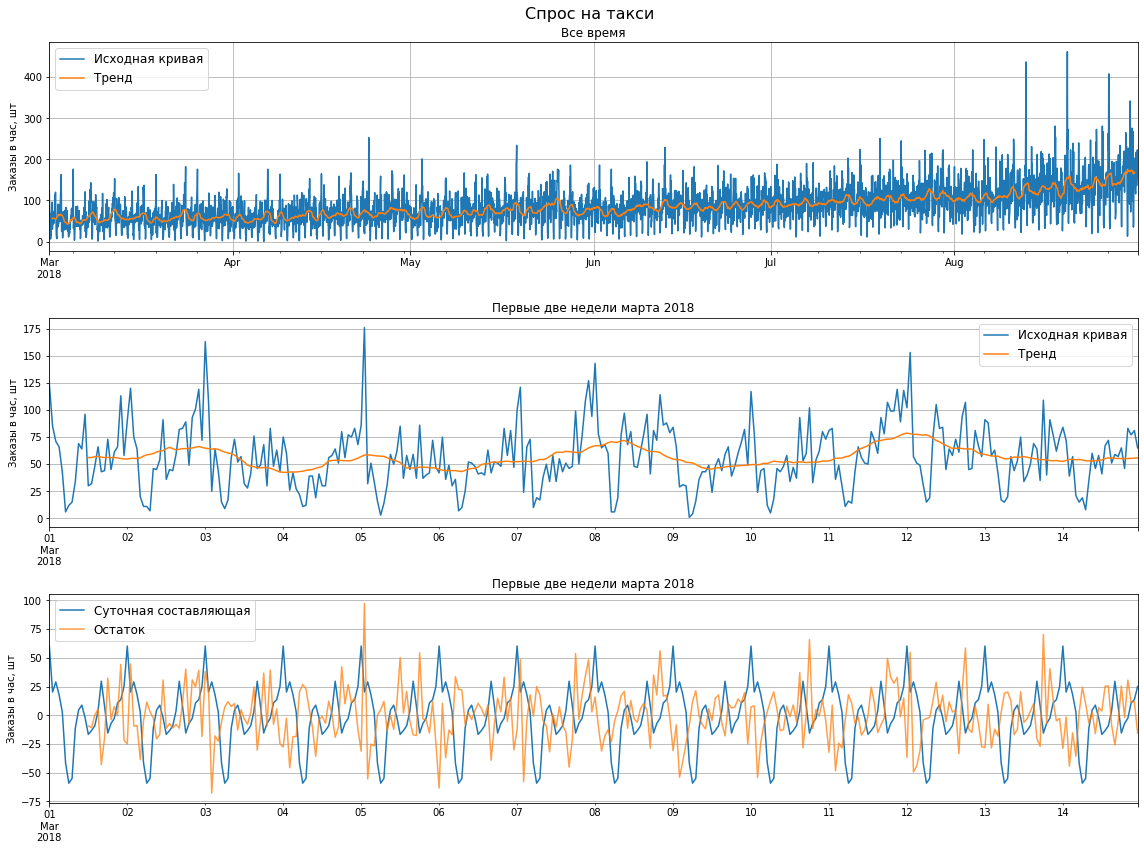

In [10]:
# Декомпозиция временного ряда
taxi_sd = seasonal_decompose(taxi)
# Красивые картинки
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
# Оси 0
taxi.plot(
    ax=axs[0]
)
taxi_sd.trend.plot(
    ax=axs[0],
    grid=True,
    xlabel='',
    ylabel='Заказы в час, шт',
    title='Все время'
)
axs[0].legend(['Исходная кривая', 'Тренд'], fontsize=12)
# Оси 1
taxi[DATE_2018_03_FIRST_HALF_SLICE].plot(
    ax=axs[1]    
)
taxi_sd.trend[DATE_2018_03_FIRST_HALF_SLICE].plot(
    ax=axs[1],
    grid=True,
    xlabel='',
    ylabel='Заказы в час, шт',
    title='Первые две недели марта 2018'
)
axs[1].legend(['Исходная кривая', 'Тренд'], fontsize=12)
# Оси 2
taxi_sd.seasonal[DATE_2018_03_FIRST_HALF_SLICE].plot(
    ax=axs[2]
)
taxi_sd.resid[DATE_2018_03_FIRST_HALF_SLICE].plot(
    ax=axs[2],
    alpha=0.75,
    grid=True,
    xlabel='',
    ylabel='Заказы в час, шт',
    title='Первые две недели марта 2018'
)
axs[2].legend(['Суточная составляющая', 'Остаток'], fontsize=12)
fig.suptitle('Спрос на такси', x=0.515, fontsize=16)
fig.tight_layout()
plt.show()

На приведенных графиках можно отметить тренд: сглаженная кривая спроса медленно растет на протяжении всего периода. Его зависимость от значений даты нелинейная. На крупномасштабных графиках хорошо выделяются суточные колебания. Остаток декомпозиции имеет значительную амплитуду. Исследуем его распределение на гистограмме.

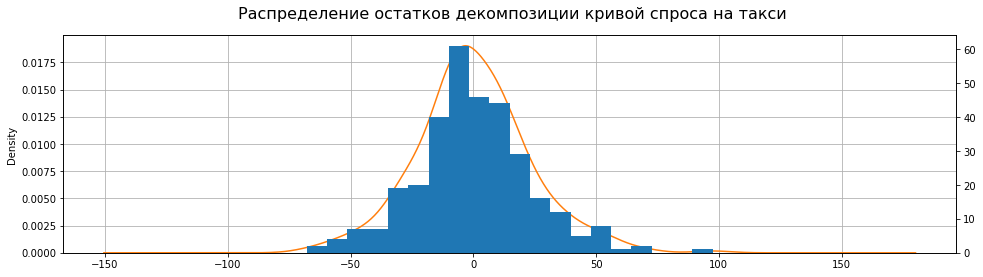

In [11]:
fig, axs = plt.subplots(figsize=(16, 4))
taxi_sd.resid[DATE_2018_03_FIRST_HALF_SLICE].plot.hist(ax=axs, bins=20, secondary_y=True)
taxi_sd.resid[DATE_2018_03_FIRST_HALF_SLICE].plot.kde(ax=axs, grid=True)
axs.set_ylim(0)
fig.suptitle('Распределение остатков декомпозиции кривой спроса на такси', x=0.515, fontsize=16)
plt.show()

Распределение близко к нормальному &mdash; остаток декомпозиции можно интерпретировать как нормальный шум.

Подберем шаги для двух скользящих средних. Первой сглаженной кривой попробуем приблизить тренд, второй &mdash; суточные осцилляции спроса.

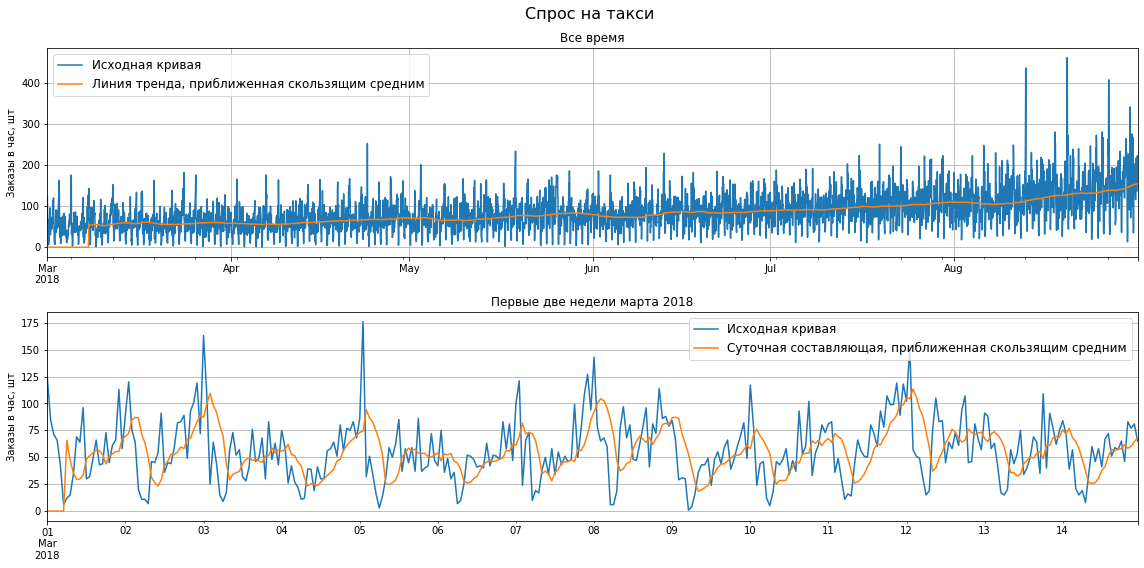

In [12]:
# Декомпозиция временного ряда
taxi_sd = seasonal_decompose(taxi)
# Красивые картинки
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
# Оси 0
taxi.plot(
    ax=axs[0]
)
taxi.shift().rolling(ROLL_IR_TREND_SIZE).mean().fillna(0).plot(
    ax=axs[0],
    grid=True,
    xlabel='',
    ylabel='Заказы в час, шт',
    title='Все время'
)
axs[0].legend(['Исходная кривая', 'Линия тренда, приближенная скользящим средним'], fontsize=12)
# Оси 1
taxi[DATE_2018_03_FIRST_HALF_SLICE].plot(
    ax=axs[1]
)
taxi[DATE_2018_03_FIRST_HALF_SLICE].shift().rolling(ROLL_IR_DAILY_SIZE).mean().fillna(0).plot(
    ax=axs[1],
    grid=True,
    xlabel='',
    ylabel='Заказы в час, шт',
    title='Первые две недели марта 2018'
)
axs[1].legend(['Исходная кривая', 'Суточная составляющая, приближенная скользящим средним'], fontsize=12)
fig.suptitle('Спрос на такси', x=0.515, fontsize=16)
fig.tight_layout()
plt.show()

Визуально трудно определить тренд в пределах одной недели, поэтому в качестве ширины окна скользящего среднего был взят соответствующий период в часах. При этом групповое запаздывание полученной линии тренда от исходных данных составило (ROLL_IR_TREND_SIZE - 1) / 2 ч, что для значения ROLL_IR_TREND_SIZE = 24 * 7 ч равняется 83.5 ч (трое с половиной суток).

Для сглаживания суточной составляющей спроса использовалось окно шириной 6 часов. Визуально кривая неплохо отражает суточные колебания, групповое время запаздывания полученной кривой от исходной будет равно (ROLL_IR_DAILY_SIZE - 1) / 2 часа, что для ROLL_IR_DAILY_SIZE = 6 ч составляет 3.5 ч.

---

Для повышения качества предсказания создадим и добавим в данные признаки с дополнительной информацией о дате и времени: число, номер дня недели, время суток с точностью до часа, отстающие значения с шагом в час, а также полученные скользящие средние. После обучения сравним важность добавленных признаков для тех моделей, которые предоставляют такую возможность.

Так как статистические данные предоставлены только за неполный 2018 год, создание отдельного константного признака для года не имеет смысла. Не очень понятно, как модели, обученные на номерах месяца с марта по август, будут осуществлять прогнозирование для объектов, имеющих иное значение месяца. Признак, содержащий номер месяца в году, также не будем добавлять в таблицу.

Количество отстающих значений выберем равным 23, чтобы с текущим значением они образовывали сутки. А че нет, когда да?

In [13]:
make_features(taxi, 23, {'rm_trend': 24 * 7, 'rm_daily': 6})
taxi.drop(columns=['year', 'month'], inplace=True)
taxi.dropna(inplace=True)
taxi.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rm_trend,rm_daily
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,8,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.226190,92.333333
2018-03-08 01:00:00,78,8,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.339286,99.666667
2018-03-08 02:00:00,65,8,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.297619,104.333333
2018-03-08 03:00:00,68,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.261905,102.500000
2018-03-08 04:00:00,60,8,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,54.273810,95.833333


Проверим добавленные признаки на мультиколлинеарность.

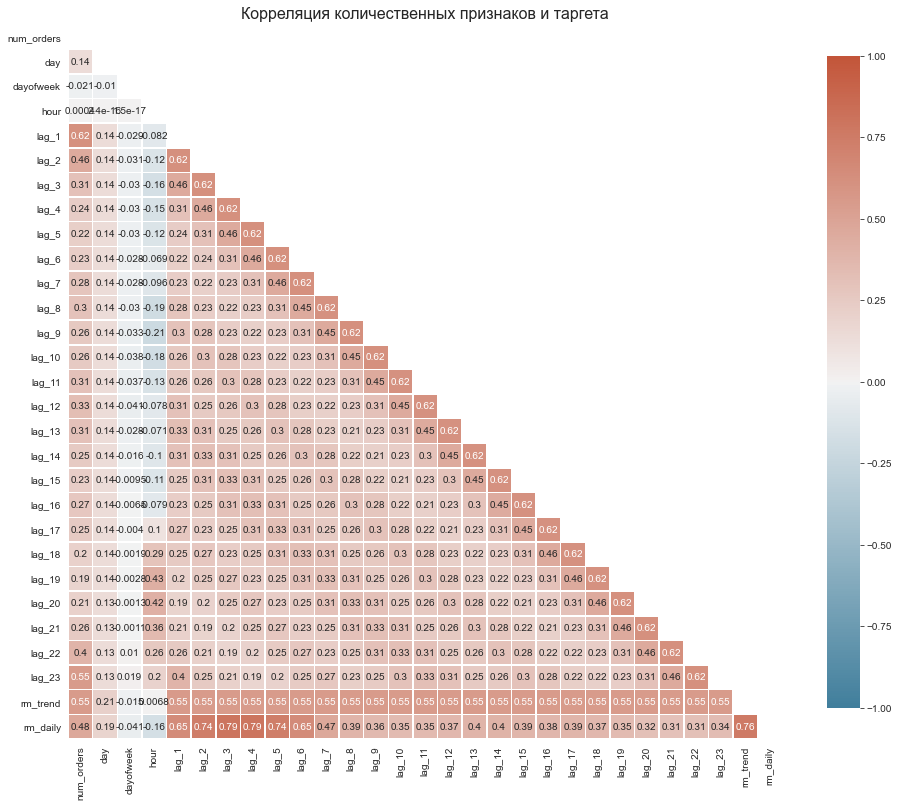

In [14]:
sns.set_style('whitegrid')
_, axs = plt.subplots(figsize=(16, 16))
corr = taxi.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1,
    square=True, linewidths=0.5, cbar_kws={'shrink': 0.75}, ax=axs, fmt='.2g'
).set_title('Корреляция количественных признаков и таргета', fontsize=16);

Все в пределах нормы. Признак **hour** демонстрируют самую слабую корреляцию с таргетом. Оставим.

Разделим подготовленные данные на тренировочную и тестовую выборки в заданном соотношении 9:1.

In [15]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state=12345)
train_X, train_Y = train.drop(columns='num_orders'), train.num_orders
test_X, test_Y = test.drop(columns='num_orders'), test.num_orders

Обучим и сравним разные модели машинного обучения.

## Обучение и тестирование моделей

### Регрессор на основе случайного леса RandomForestRegressor

Обучим модель регрессора на основе случайного леса для различных значений гиперпараметров. Для корректного разбиения обучающих данных на обучающую и валидационную выборки с сохранением хронологического порядка во время кросс-валидации воспользуемся модулем `TimeSeriesSplit` библиотеки Scikit Learn. Будем использовать стандартные параметры кросс-валидации (5 разбиений).

In [16]:
# Значения гиперпараметров
parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 20, 50],
    'random_state': [12345]
}
# Обучение и выбор лучшей модели
rfr_gsc = GridSearchCV(
    RandomForestRegressor(),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    refit=True,
    verbose=3
)
rfr_gsc.fit(train_X, train_Y)
#rfr_gsc.cv_results_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=1, n_estimators=10, random_state=12345; total time=   0.0s
[CV 2/5] END max_depth=1, n_estimators=10, random_state=12345; total time=   0.0s
[CV 3/5] END max_depth=1, n_estimators=10, random_state=12345; total time=   0.0s
[CV 4/5] END max_depth=1, n_estimators=10, random_state=12345; total time=   0.0s
[CV 5/5] END max_depth=1, n_estimators=10, random_state=12345; total time=   0.0s
[CV 1/5] END max_depth=1, n_estimators=50, random_state=12345; total time=   0.0s
[CV 2/5] END max_depth=1, n_estimators=50, random_state=12345; total time=   0.0s
[CV 3/5] END max_depth=1, n_estimators=50, random_state=12345; total time=   0.0s
[CV 4/5] END max_depth=1, n_estimators=50, random_state=12345; total time=   0.0s
[CV 5/5] END max_depth=1, n_estimators=50, random_state=12345; total time=   0.1s
[CV 1/5] END max_depth=1, n_estimators=100, random_state=12345; total time=   0.0s
[CV 2/5] END max_depth=1, n_estimator

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 20, 50],
                         'n_estimators': [10, 50, 100],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error', verbose=3)

Лучшее значение RMSE на валидационной выборке и соответствующие гиперпараметры модели.

In [17]:
abs(rfr_gsc.best_score_), rfr_gsc.best_params_

(25.672772813198673,
 {'max_depth': 50, 'n_estimators': 100, 'random_state': 12345})

Построим диаграмму распределения признаков обучающей выборки по важности для лучшего обученного регрессора на основе случайного леса.

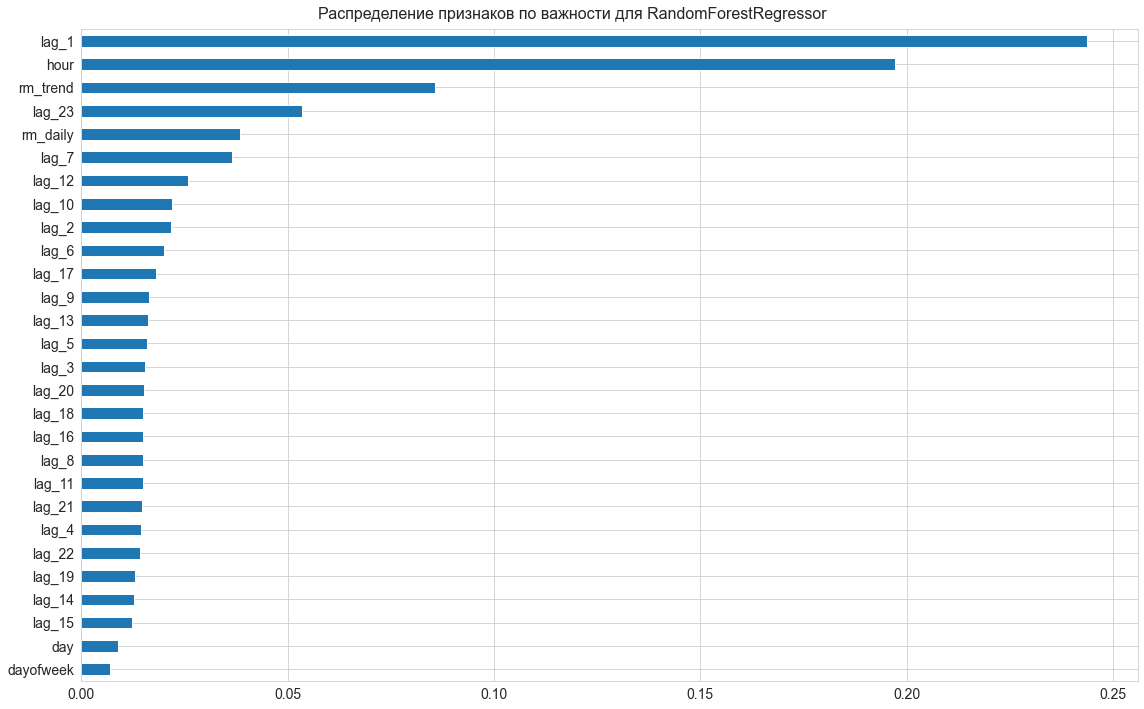

In [18]:
rfr_fi = pd.Series(rfr_gsc.best_estimator_.feature_importances_, index=train_X.columns)
rfr_fi.sort_values(ascending=False, inplace=True)
fig, axs = plt.subplots(figsize=(16, 10))
rfr_fi.plot.barh(
    ax=axs,
    grid=True,
    fontsize=14);
fig.suptitle('Распределение признаков по важности для RandomForestRegressor', fontsize=16)
axs.invert_yaxis()
fig.tight_layout()
plt.show()

В первую тройку важнейших признаков вошли:
- значения временного ряда, отстающее на 1 час **lag_1**;
- время суток в часах **hour**;
- приближение линии тренда скользящим средним с шириной окна 168 часов (24 ч * 7 д) **rm_trend**.

Также стоит отметить высокие значения важности значения временного ряда, отстающего на 23 часа, **lag_23**, а также суточной составляющей спроса **rm_daily**, полученной сглаживанием исходной кривой скользящим средним с шириной окна 6 ч, расположившиеся на 4 и 5 местах соответственно.

Основная масса признаков, представляющих собой значения, отстающие на разное количество часов, имеет более-менее близкую и при этом достаточно существенную важность.

Значения важности номера дня недели **dayofweek** и числа месяца **day** также оказались внизу списка.

### Линейный регрессор LinearRegression

Обучим простой линейный регрессор.

In [19]:
# Значения гиперпараметров
parameters = {
    # normalize с временными признаками - это как-то странно, а еще его скоро удалят из списка гиперпараметров :)
}
# Обучение и выбор лучшей модели
lr_gsc = GridSearchCV(
    LinearRegression(),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    refit=True,
    verbose=3
)
lr_gsc.fit(train_X, train_Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................................................ total time=   0.0s
[CV 2/5] END ................................................ total time=   0.0s
[CV 3/5] END ................................................ total time=   0.0s
[CV 4/5] END ................................................ total time=   0.0s
[CV 5/5] END ................................................ total time=   0.0s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error', verbose=3)

Лучшее значение RMSE на валидационной выборке и соответствующие гиперпараметры модели.

In [20]:
abs(lr_gsc.best_score_), lr_gsc.best_params_

(29.618553655679897, {})

### Линейный регрессор с объединением L1 и L2 регуляризаций ElasticNet

Обучим линейный регрессор, использующий одновременно L1 и L2 регуляризации для борьбы с переобучением.

In [21]:
# Значения гиперпараметров
parameters = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.025, 0.5, 0.75], 
    'tol': [1e-6, 1e-4, 1e-2],
    'selection': ['cyclic', 'random'],
    'normalize': [False, True],
    'random_state': [12345]
}
# Обучение и выбор лучшей модели
en_gsc = GridSearchCV(
    ElasticNet(),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    refit=True,
    verbose=1 # 3
)
en_gsc.fit(train_X, train_Y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.025, 0.5, 0.75],
                         'normalize': [False, True], 'random_state': [12345],
                         'selection': ['cyclic', 'random'],
                         'tol': [1e-06, 0.0001, 0.01]},
             scoring='neg_root_mean_squared_error', verbose=1)

Лучшее значение RMSE на валидационной выборке и соответствующие гиперпараметры модели.

In [22]:
abs(en_gsc.best_score_), en_gsc.best_params_

(29.417222182411855,
 {'alpha': 10,
  'l1_ratio': 0.025,
  'normalize': False,
  'random_state': 12345,
  'selection': 'cyclic',
  'tol': 0.01})

## Сравнение моделей и выводы

Вычислим значения RMSE метрики для лучших моделей каждого типа на тестовых данных.

In [23]:
# Предсказания тестовых данных
rfr_best_pred = pd.Series(rfr_gsc.best_estimator_.predict(test_X), index=test_X.index)
lr_best_pred = pd.Series(lr_gsc.best_estimator_.predict(test_X), index=test_X.index)
en_best_pred = pd.Series(en_gsc.best_estimator_.predict(test_X), index=test_X.index)
# Сравнительная таблица
comparison = pd.DataFrame(
    [
        [mean_squared_error(test_Y, rfr_best_pred) ** 0.5],
        [mean_squared_error(test_Y, lr_best_pred) ** 0.5],
        [mean_squared_error(test_Y, en_best_pred) ** 0.5]
    ],
    columns=['RSME на тестовой выборке'],
    index=['RandomForestRegressor', 'LinearRegression', 'ElasticNet']
)
comparison.index.name = 'Модель'
comparison.columns.name = 'Метрика'
comparison.sort_values(by='RSME на тестовой выборке')
comparison

Метрика,RSME на тестовой выборке
Модель,
RandomForestRegressor,43.271207
LinearRegression,44.512484
ElasticNet,44.606478


Лучший результат удалось достичь при использовании регрессора на основе случайного леса **RandomForestRegressor**. В целом же полученные значения метрик достаточно близки, особенно для **LinearRegression** и **ElasticNet**, что может объясняться отсутствием проблемы переобучения в данной задаче.

Построим на графиках результаты предсказания тестовой выборки исследуемыми моделями.

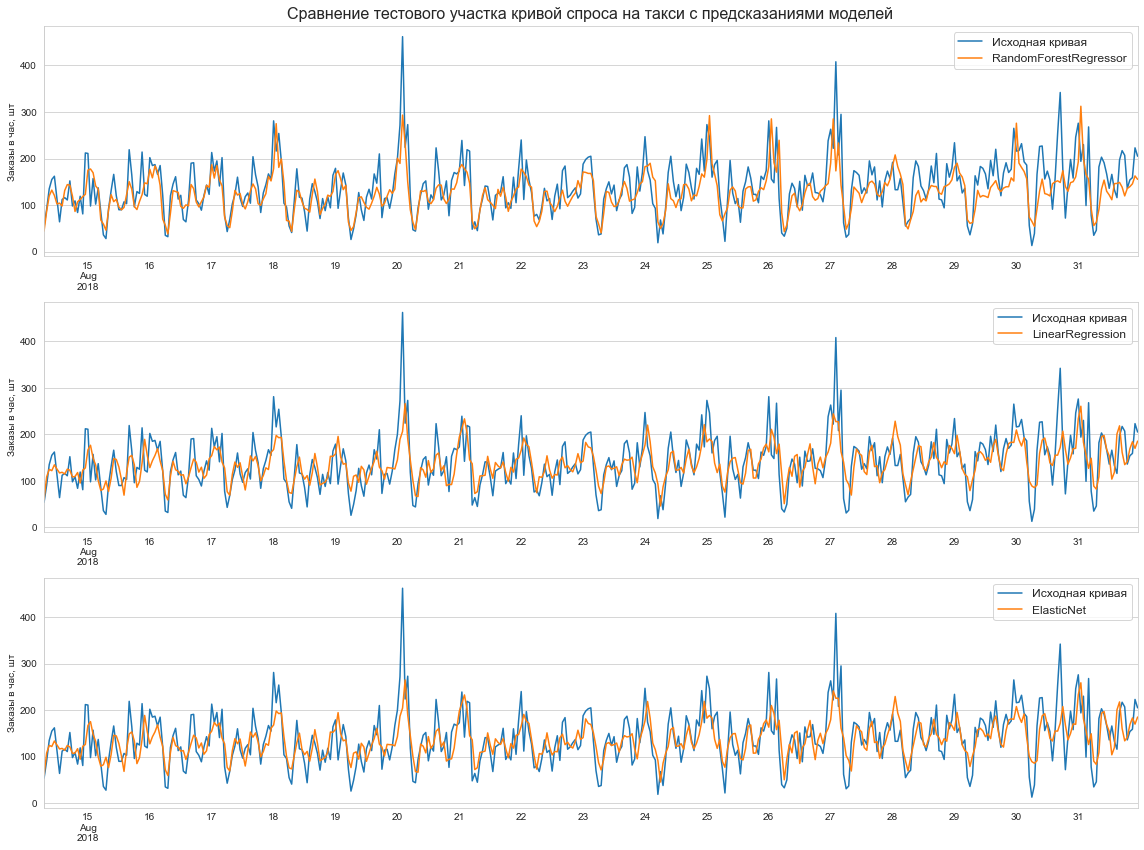

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
# Оси 0
test_Y.plot(ax=axs[0])
rfr_best_pred.plot(ax=axs[0], grid=True, xlabel='', ylabel='Заказы в час, шт')
axs[0].legend(['Исходная кривая', 'RandomForestRegressor'], fontsize=12)
# Оси 1
test_Y.plot(ax=axs[1])
lr_best_pred.plot(ax=axs[1], grid=True, xlabel='', ylabel='Заказы в час, шт')
axs[1].legend(['Исходная кривая', 'LinearRegression'], fontsize=12)
# Оси 2
test_Y.plot(ax=axs[2])
en_best_pred.plot(ax=axs[2], grid=True, xlabel='', ylabel='Заказы в час, шт')
axs[2].legend(['Исходная кривая', 'ElasticNet'], fontsize=12)
fig.suptitle('Сравнение тестового участка кривой спроса на такси с предсказаниями моделей', x=0.515, fontsize=16)
fig.tight_layout()
plt.show()

Также визуализируем кривые квадратов ошибок для каждой из моделей в общих осях.

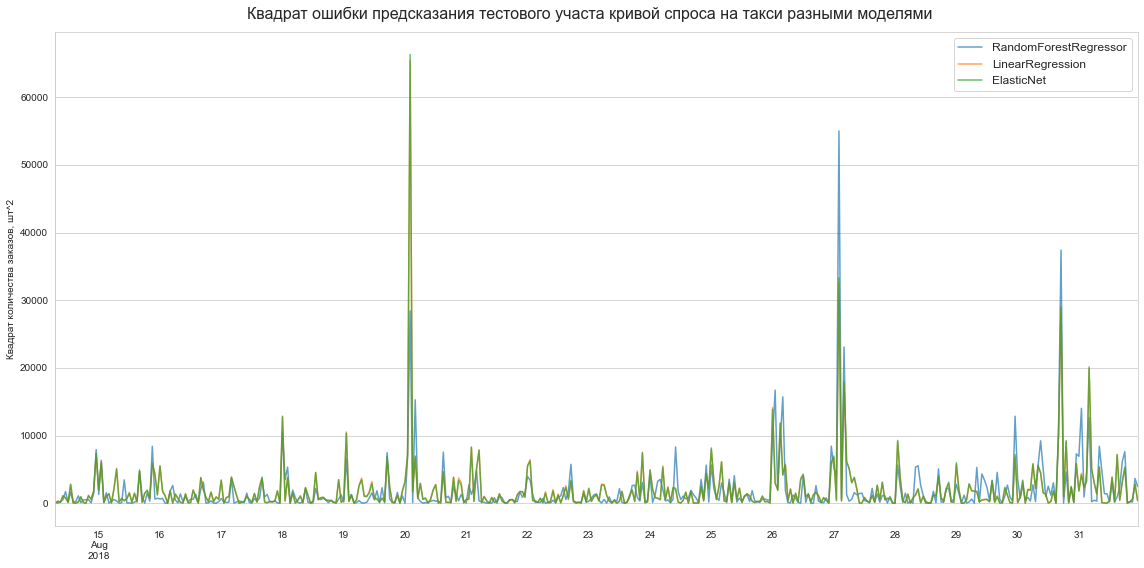

In [25]:
fig, axs = plt.subplots(figsize=(16, 8))
((rfr_best_pred - test_Y)**2).plot(ax=axs, alpha=0.7)
((lr_best_pred - test_Y)**2).plot(ax=axs, alpha=0.7)
((en_best_pred - test_Y)**2).plot(ax=axs, alpha=0.7, grid=True, xlabel='', ylabel='Квадрат количества заказов, шт^2')
axs.legend(['RandomForestRegressor', 'LinearRegression', 'ElasticNet'], fontsize=12)
fig.suptitle('Квадрат ошибки предсказания тестового участа кривой спроса на такси разными моделями', x=0.515, fontsize=16)
fig.tight_layout()
plt.show()

Кривые квадратов ошибок также имеют схожие очертания. Для **LinearRegression** и **ElasticNet** они и вовсе совпадают (оранжевая кривая спряталась за зеленой). Можно отметить, что все модели испытывают сложности и с предсказанием пиковых значений. При этом величина ошибки пропорциональна величине пика. В точности предсказания самых крупных пиков трудно выделить победителя: для некоторых из них величина ошибки **RandomForestRegressor** меньше, чем у остальных моделей, для других &mdash; наоборот.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48